# Imports

Ce code charge et traite des données du fichier CSV. D'abord, il importe plusieurs bibliothèques pour la manipulation de données, les statistiques, l'imputation de valeurs manquantes et l'analyse de données. Ensuite, il lit le fichier CSV par morceaux de 1000 lignes pour calculer le taux de valeurs manquantes par colonne. Si ces taux sont inférieurs à 70%, les colonnes correspondantes sont conservées pour le chargement complet du fichier filtré. Après cela, il supprime plusieurs colonnes spécifiques non nécessaires à l'analyse et remplace les valeurs manquantes dans la colonne 'countries' par des chaînes vides. Enfin, il filtre les lignes de données pour ne conserver que celles où la colonne 'countries' contient des mots clés spécifiques comme 'France' ou ses variantes.

In [273]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import time
import scipy.stats as stats
from scipy.spatial import ConvexHull
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, KNNImputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.covariance import MinCovDet

start_time = time.time()

chunksize = 10 ** 3  # Chunksize de 1000 lignes
filename = 'products.csv'
nan_rates = []

try:
    reader = pd.read_csv(filename, chunksize=chunksize, sep='\t')

    for chunk in reader:
        nan_rates.append(chunk.isna().mean(axis=0))

except pd.errors.ParserError as e:
    print(f"ParserError: {e}")

# Calcul des taux moyens de remplissage des chunks
if nan_rates:
    inds_nan_rate = pd.concat(nan_rates, axis=1).mean(axis=1)
    cols_to_load = inds_nan_rate[inds_nan_rate < 0.7].index.tolist()

    # Chargement des données filtrées
    df = pd.read_csv(filename, sep='\t', usecols=cols_to_load)

    # Affichage des 10 premières lignes du DataFrame avant la suppression des colonnes
    #print("Affichage des 10 premières lignes du DataFrame avant la suppression des colonnes :")
    #print(df.head(10))
    
    df = df.drop(['url','states','additives_n','nutrition-score-fr_100g','energy_100g','main_category','completeness','nutrient_levels_tags','brands','nova_group','food_groups','categories','creator','serving_size','serving_quantity','categories','image_nutrition_url','ingredients_analysis_tags','ingredients_tags','ingredients_text','image_nutrition_small_url','created_datetime','food_groups_tags','food_groups_en','states_tags','sodium_100g','states_en','last_image_datetime','last_modified_t','last_modified_datetime','created_t','last_modified_by','main_category_en','image_url','image_small_url','last_updated_t','last_image_t','brands_tags','last_updated_datetime','categories_en','categories_tags','countries_tags','countries_en'], axis=1)

# Remplacer les valeurs NaN par une chaîne vide pour éviter les erreurs de filtrage
df['countries'].fillna('', inplace=True)  

# Liste des mots clés à rechercher dans la colonne 'countries'
keywords = ['France', 'French', 'Francia', 'Frankreich', 'Polynésie française', 'FR', 'fr']

# Filtrer les lignes où 'countries' ne contient pas les mots clés spécifiés
mask = df['countries'].str.contains('|'.join(keywords), case=False, na=False)
df = df[mask]

ParserError: Error tokenizing data. C error: Expected 206 fields in line 1537879, saw 234



/var/folders/25/t6v1433n06x6vfl9wjbxn8sw0000gn/T/ipykernel_1820/1045784456.py:36: DtypeWarning: Columns (0,50,52,56,58,88,89,91,92) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(filename, sep='\t', usecols=cols_to_load)


# Informations Dataframe

In [275]:
df.info

<bound method DataFrame.info of                          code                  product_name        countries  \
0           00000000000000225                jeunes pousses        en:france   
3        00000000000026772226                          Skyr           France   
4               0000000000017              Vitória crackers           France   
5               0000000000031                         Cacao           France   
11              0000000000100   moutarde au moût de raisin            France   
...                       ...                           ...              ...   
3307643              99999995                Steak haché 5%           France   
3307647         9999999905667                           NaN  en:South Africa   
3307649         9999999916298       Beurre de cacahuète bio            en:fr   
3307652             999999999       Thé noir BIO Darjeeling        en:france   
3307657         9999999999994     Light & Free SKYR A BOIRE        en:france   

       

In [276]:
df.head(5)

,code,product_name,countries,nutriscore_score,nutriscore_grade,pnns_groups_1,pnns_groups_2,ecoscore_grade,energy-kcal_100g,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,fruits-vegetables-nuts-estimate-from-ingredients_100g
0,00000000000000225,jeunes pousses,en:france,NaN,unknown,Fruits and vegetables,Vegetables,b,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,00000000000026772226,Skyr,France,-5.00,a,Milk and dairy products,Dairy desserts,b,57.00,0.20,0.10,3.90,3.90,NaN,10.00,0.09,NaN
4,0000000000017,Vitória crackers,France,NaN,unknown,unknown,unknown,unknown,375.00,7.00,3.08,70.10,15.00,NaN,7.80,1.40,NaN
5,0000000000031,Cacao,France,NaN,unknown,unknown,unknown,unknown,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11,0000000000100,moutarde au moût de raisin,France,18.00,d,Fat and sauces,Dressings and sauces,c,NaN,8.20,2.20,29.00,22.00,0.00,5.10,4.60,0.00


In [277]:
df.dtypes

code                                                      object
product_name                                              object
countries                                                 object
nutriscore_score                                          object
nutriscore_grade                                          object
pnns_groups_1                                             object
pnns_groups_2                                             object
ecoscore_grade                                            object
energy-kcal_100g                                          object
fat_100g                                                  object
saturated-fat_100g                                        object
carbohydrates_100g                                       float64
sugars_100g                                              float64
fiber_100g                                               float64
proteins_100g                                            float64
salt_100g                

In [278]:
df.isna().sum()

code                                                          0
product_name                                              35036
countries                                                     0
nutriscore_score                                         657501
nutriscore_grade                                           9708
pnns_groups_1                                              1044
pnns_groups_2                                              1042
ecoscore_grade                                             1240
energy-kcal_100g                                         278680
fat_100g                                                 262330
saturated-fat_100g                                       259299
carbohydrates_100g                                       262180
sugars_100g                                              259558
fiber_100g                                               797971
proteins_100g                                            260593
salt_100g                               

# Fonction Nettoyage Données

Cette fonction clean_and_impute_data nettoie et impute les données d'un DataFrame. Elle commence par supprimer les lignes contenant des caractères cyrilliques dans la colonne 'product_name', élimine les doublons basés sur le code du produit, et enlève les lignes avec des valeurs NaN dans 'product_name'. Ensuite, elle corrige les valeurs des colonnes nutritionnelles (ex. 'fat_100g') pour qu'elles soient entre 0 et 100, et impute les valeurs manquantes en utilisant une méthode itérative. La fonction redistribue aussi les valeurs des nutriments si leur somme dépasse 100, supprime les lignes avec des valeurs nutritionnelles négatives après imputation, et élimine les lignes où 'energy-kcal_100g' est supérieur à 900. Enfin, elle impute les valeurs manquantes dans certaines colonnes en utilisant des moyennes ou des modalités les plus fréquentes.

In [281]:
def clean_and_impute_data(df):
    
    def detect_and_remove_cyrillic(df, column):
        cyrillic_pattern = re.compile(r'[\u0400-\u04FF]+')
        mask = df[column].apply(lambda x: bool(cyrillic_pattern.search(str(x))))
        df.drop(df[mask].index, inplace=True)
        df.reset_index(drop=True, inplace=True)
        print(f"\nNombre de lignes supprimées : {mask.sum()}")
        print("Étape de suppression des caractères cyrilliques complétée.")
    
    def redistribute_nutrient_values(df, columns_to_check, max_sum=100):
        nutrient_sum = df[columns_to_check].sum(axis=1)
        mask = nutrient_sum > max_sum
        total = df.loc[mask, columns_to_check].sum(axis=1)
        factor = max_sum / total
        df.loc[mask, columns_to_check] *= factor.values[:, None]
    
    def check_nutrient_sum(df):
        columns_to_check = ['fat_100g', 'sugars_100g', 'fiber_100g', 'proteins_100g', 'salt_100g', 'carbohydrates_100g', 'fruits-vegetables-nuts-estimate-from-ingredients_100g']
        nutrient_sum = df[columns_to_check].sum(axis=1)
        mask = nutrient_sum > 100
        count_high_sum = mask.sum()
        if count_high_sum > 0:
            print(f"\nNombre de lignes avec une somme strictement supérieure à 100 : {count_high_sum}")
        else:
            print("Aucune ligne avec une somme des colonnes strictement supérieure à 100 trouvée.")
        
        return count_high_sum
    
    # Suppression cyrillique
    detect_and_remove_cyrillic(df, 'product_name')
    
    # Suppression des doublons basés sur le code
    df.drop_duplicates(subset='code', inplace=True)
    print("Étape de suppression des doublons basée sur le code complétée.")
    
    # Suppression des lignes avec des valeurs NaN dans 'product_name'
    df.dropna(subset=['product_name'], inplace=True)
    print(f"\nNombre de lignes supprimées avec NaN dans 'product_name': {df.shape[0] - df.dropna(subset=['product_name']).shape[0]}")
    print("Étape de suppression des lignes avec des NaN dans 'product_name' complétée.")
    
    # Remplacement des valeurs >100 par la moyenne en fonction du 'product_name'
    columns_to_check = [
        'fat_100g', 'saturated-fat_100g', 'carbohydrates_100g',
        'sugars_100g', 'fiber_100g', 'proteins_100g', 'salt_100g', 
        'fruits-vegetables-nuts-estimate-from-ingredients_100g'
    ]
    
    df[columns_to_check] = df[columns_to_check].apply(pd.to_numeric, errors='coerce')
    means = df.groupby('product_name')[columns_to_check].transform('mean')
    
    df[columns_to_check] = np.where(df[columns_to_check] > 100, means, df[columns_to_check])
    
    values_above_100 = df[columns_to_check] > 100
    count_above_100 = values_above_100.sum().sum()
    print(f"Nombre de valeurs supérieures à 100 après correction : {count_above_100}")
    
    df.drop(df[values_above_100.any(axis=1)].index, inplace=True)
    print("Étape de remplacement des valeurs >100 par la moyenne complétée.")
    
    # Préparer les données pour l'imputation
    df[columns_to_check] = df[columns_to_check].applymap(lambda x: np.nan if x < 0 else x)
    
    # Imputation itérative des NaN
    imputer = IterativeImputer(max_iter=50, random_state=0, min_value=0, max_value=100)
    df_imputed = df.copy()
    df_imputed[columns_to_check] = imputer.fit_transform(df[columns_to_check])
    df_imputed[columns_to_check] = df_imputed[columns_to_check].clip(0, 100)
    df[columns_to_check] = df_imputed[columns_to_check]
    
    print("Étape d'imputation itérative des NaN et des valeurs négatives complétée.")
    
    # Suppression des lignes avec des valeurs négatives après imputation
    df = df[df[columns_to_check].ge(0).all(axis=1)]
    
    print("Étape de suppression des lignes avec des valeurs négatives complétée.")
    
    # Suppression des lignes où 'energy-kcal_100g' est supérieur à 900
    df['energy-kcal_100g'] = pd.to_numeric(df['energy-kcal_100g'], errors='coerce')
    df = df[df['energy-kcal_100g'] <= 900]
    print("Étape de suppression des lignes où 'energy-kcal_100g' est supérieur à 900 complétée.")
    
    # Redistribution des valeurs si la somme des colonnes dépasse 100
    modified_counter = check_nutrient_sum(df)
    print(f"\nNombre de valeurs modifiées pendant la redistribution : {modified_counter}")
    print("Étape de redistribution des valeurs complétée.")
    
    # Imputation itérative en utilisant d'autres colonnes pour guider l'imputation
    imputer = IterativeImputer(max_iter=100, random_state=10, min_value=0, max_value=900)
    columns_to_impute = ['energy-kcal_100g', 'fat_100g', 'sugars_100g', 'saturated-fat_100g', 'carbohydrates_100g', 'fiber_100g', 'proteins_100g', 'salt_100g', 'fruits-vegetables-nuts-estimate-from-ingredients_100g']
    df[columns_to_impute] = imputer.fit_transform(df[columns_to_impute])
    df = df.round(2)
    print("Étape de Iterative Imputer terminée")

    # Remplacer les valeurs "unknown" par NaN dans pnns_groups_1 et pnns_groups_2
    valeurs_unknown_remplacees = 0
    valeurs_pnns_groups_2_imputees = 0

    # Remplacer les valeurs "unknown" par NaN dans pnns_groups_1 et pnns_groups_2
    valeurs_unknown_remplacees += (df['pnns_groups_1'] == "unknown").sum()
    valeurs_unknown_remplacees += (df['pnns_groups_2'] == "unknown").sum()
    df['pnns_groups_1'].replace("unknown", np.nan, inplace=True)
    df['pnns_groups_2'].replace("unknown", np.nan, inplace=True)

    # Imputation des NaN dans 'pnns_groups_2' par la modalité la plus fréquente en fonction de 'product_name'
    df['pnns_groups_2'] = df.groupby('product_name')['pnns_groups_2'].transform(
        lambda x: x.fillna(x.mode()[0] if not x.mode().empty else np.nan)
    )
    valeurs_pnns_groups_2_imputees = df['pnns_groups_2'].isna().sum()

    # Afficher les compteurs
    print(f"Valeurs 'unknown' remplacées par NaN : {valeurs_unknown_remplacees}")
    print(f"Valeurs imputées dans 'pnns_groups_2' : {valeurs_pnns_groups_2_imputees}")

    return df
    
df = clean_and_impute_data(df)


Nombre de lignes supprimées : 424
Étape de suppression des caractères cyrilliques complétée.
Étape de suppression des doublons basée sur le code complétée.

Nombre de lignes supprimées avec NaN dans 'product_name': 0
Étape de suppression des lignes avec des NaN dans 'product_name' complétée.
Nombre de valeurs supérieures à 100 après correction : 1290
Étape de remplacement des valeurs >100 par la moyenne complétée.


/var/folders/25/t6v1433n06x6vfl9wjbxn8sw0000gn/T/ipykernel_1820/1320955492.py:62: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df[columns_to_check] = df[columns_to_check].applymap(lambda x: np.nan if x < 0 else x)


Étape d'imputation itérative des NaN et des valeurs négatives complétée.
Étape de suppression des lignes avec des valeurs négatives complétée.
Étape de suppression des lignes où 'energy-kcal_100g' est supérieur à 900 complétée.

Nombre de lignes avec une somme strictement supérieure à 100 : 271585

Nombre de valeurs modifiées pendant la redistribution : 271585
Étape de redistribution des valeurs complétée.
Étape de Iterative Imputer terminée
Valeurs 'unknown' remplacées par NaN : 820314
Valeurs imputées dans 'pnns_groups_2' : 315796


# Visualisations

## Matrice de corrélation

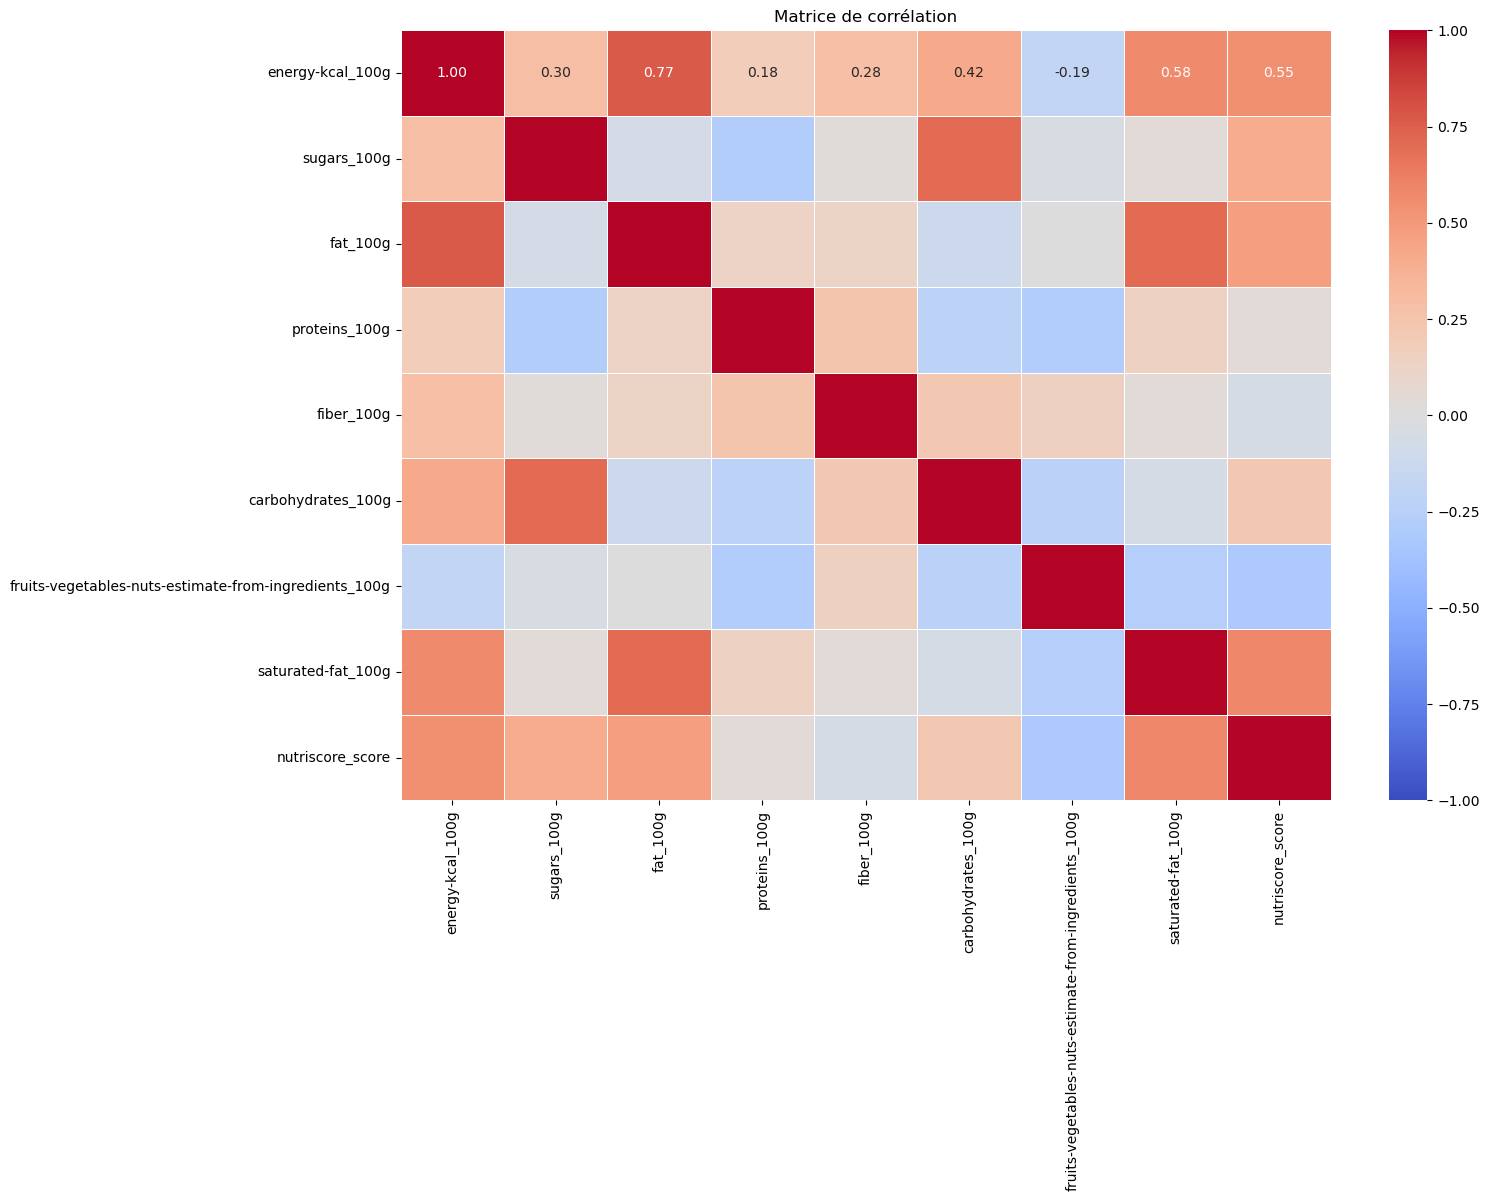

In [284]:
correlation_matrix = df[['energy-kcal_100g', 'sugars_100g', 'fat_100g', 'proteins_100g', 'fiber_100g', 'carbohydrates_100g', 'fruits-vegetables-nuts-estimate-from-ingredients_100g', 'saturated-fat_100g', 'nutriscore_score']].corr()
plt.figure(figsize=(15, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0, linewidths=.5, fmt=".2f", annot_kws={"size": 10})
plt.title('Matrice de corrélation')
plt.show()

## Graphes

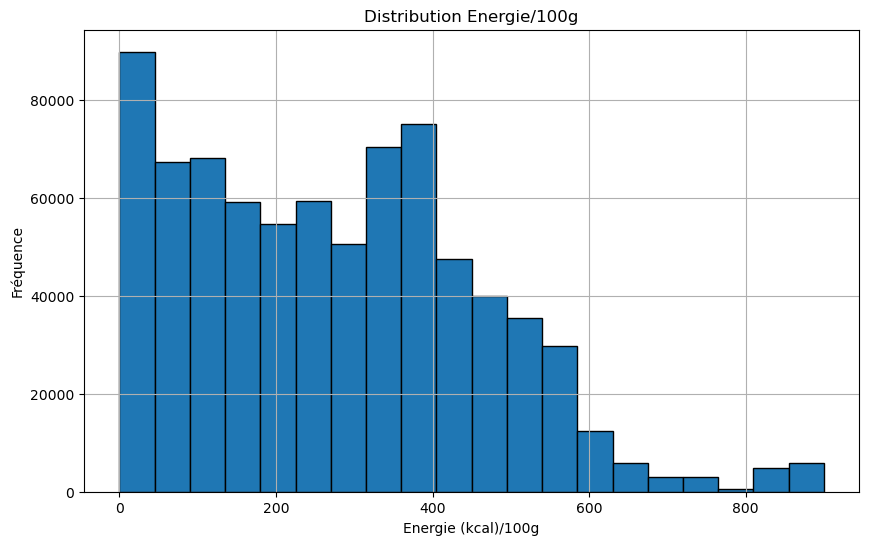

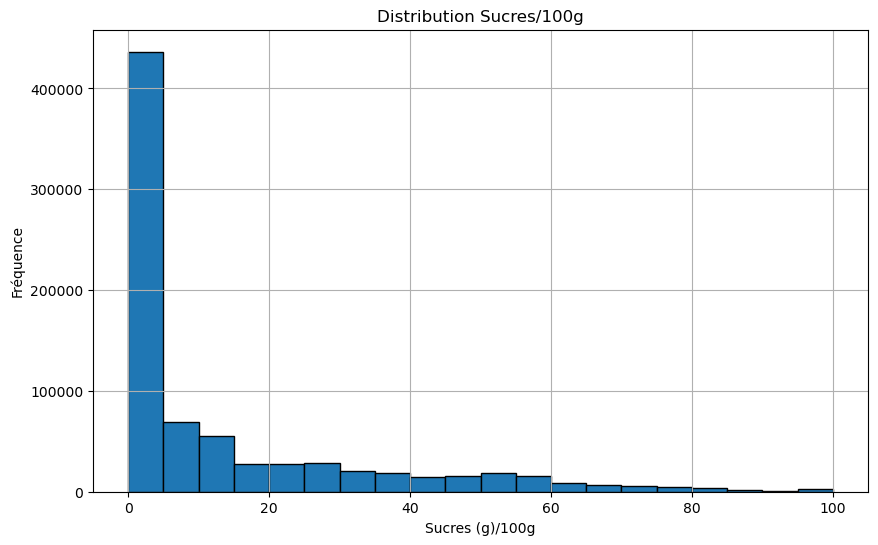

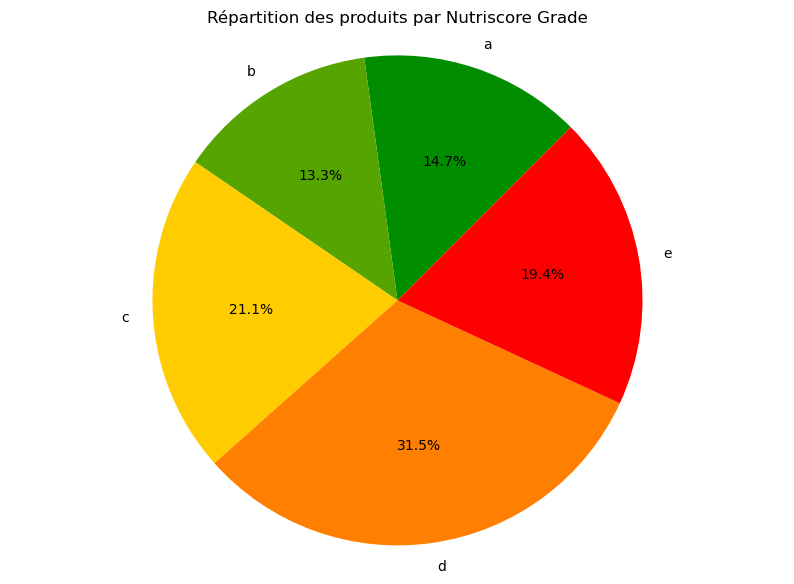

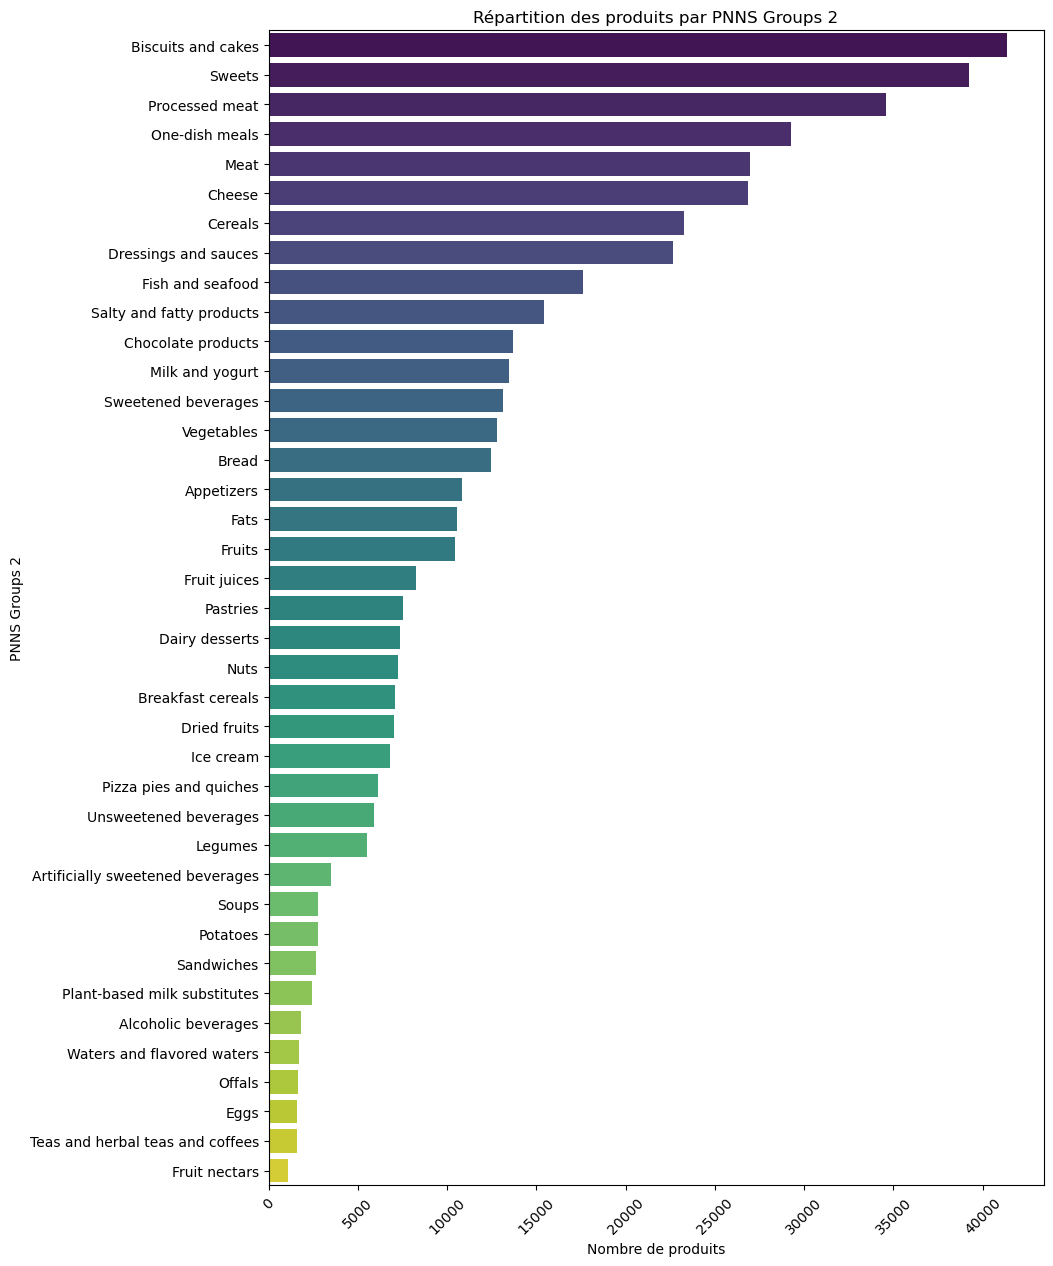

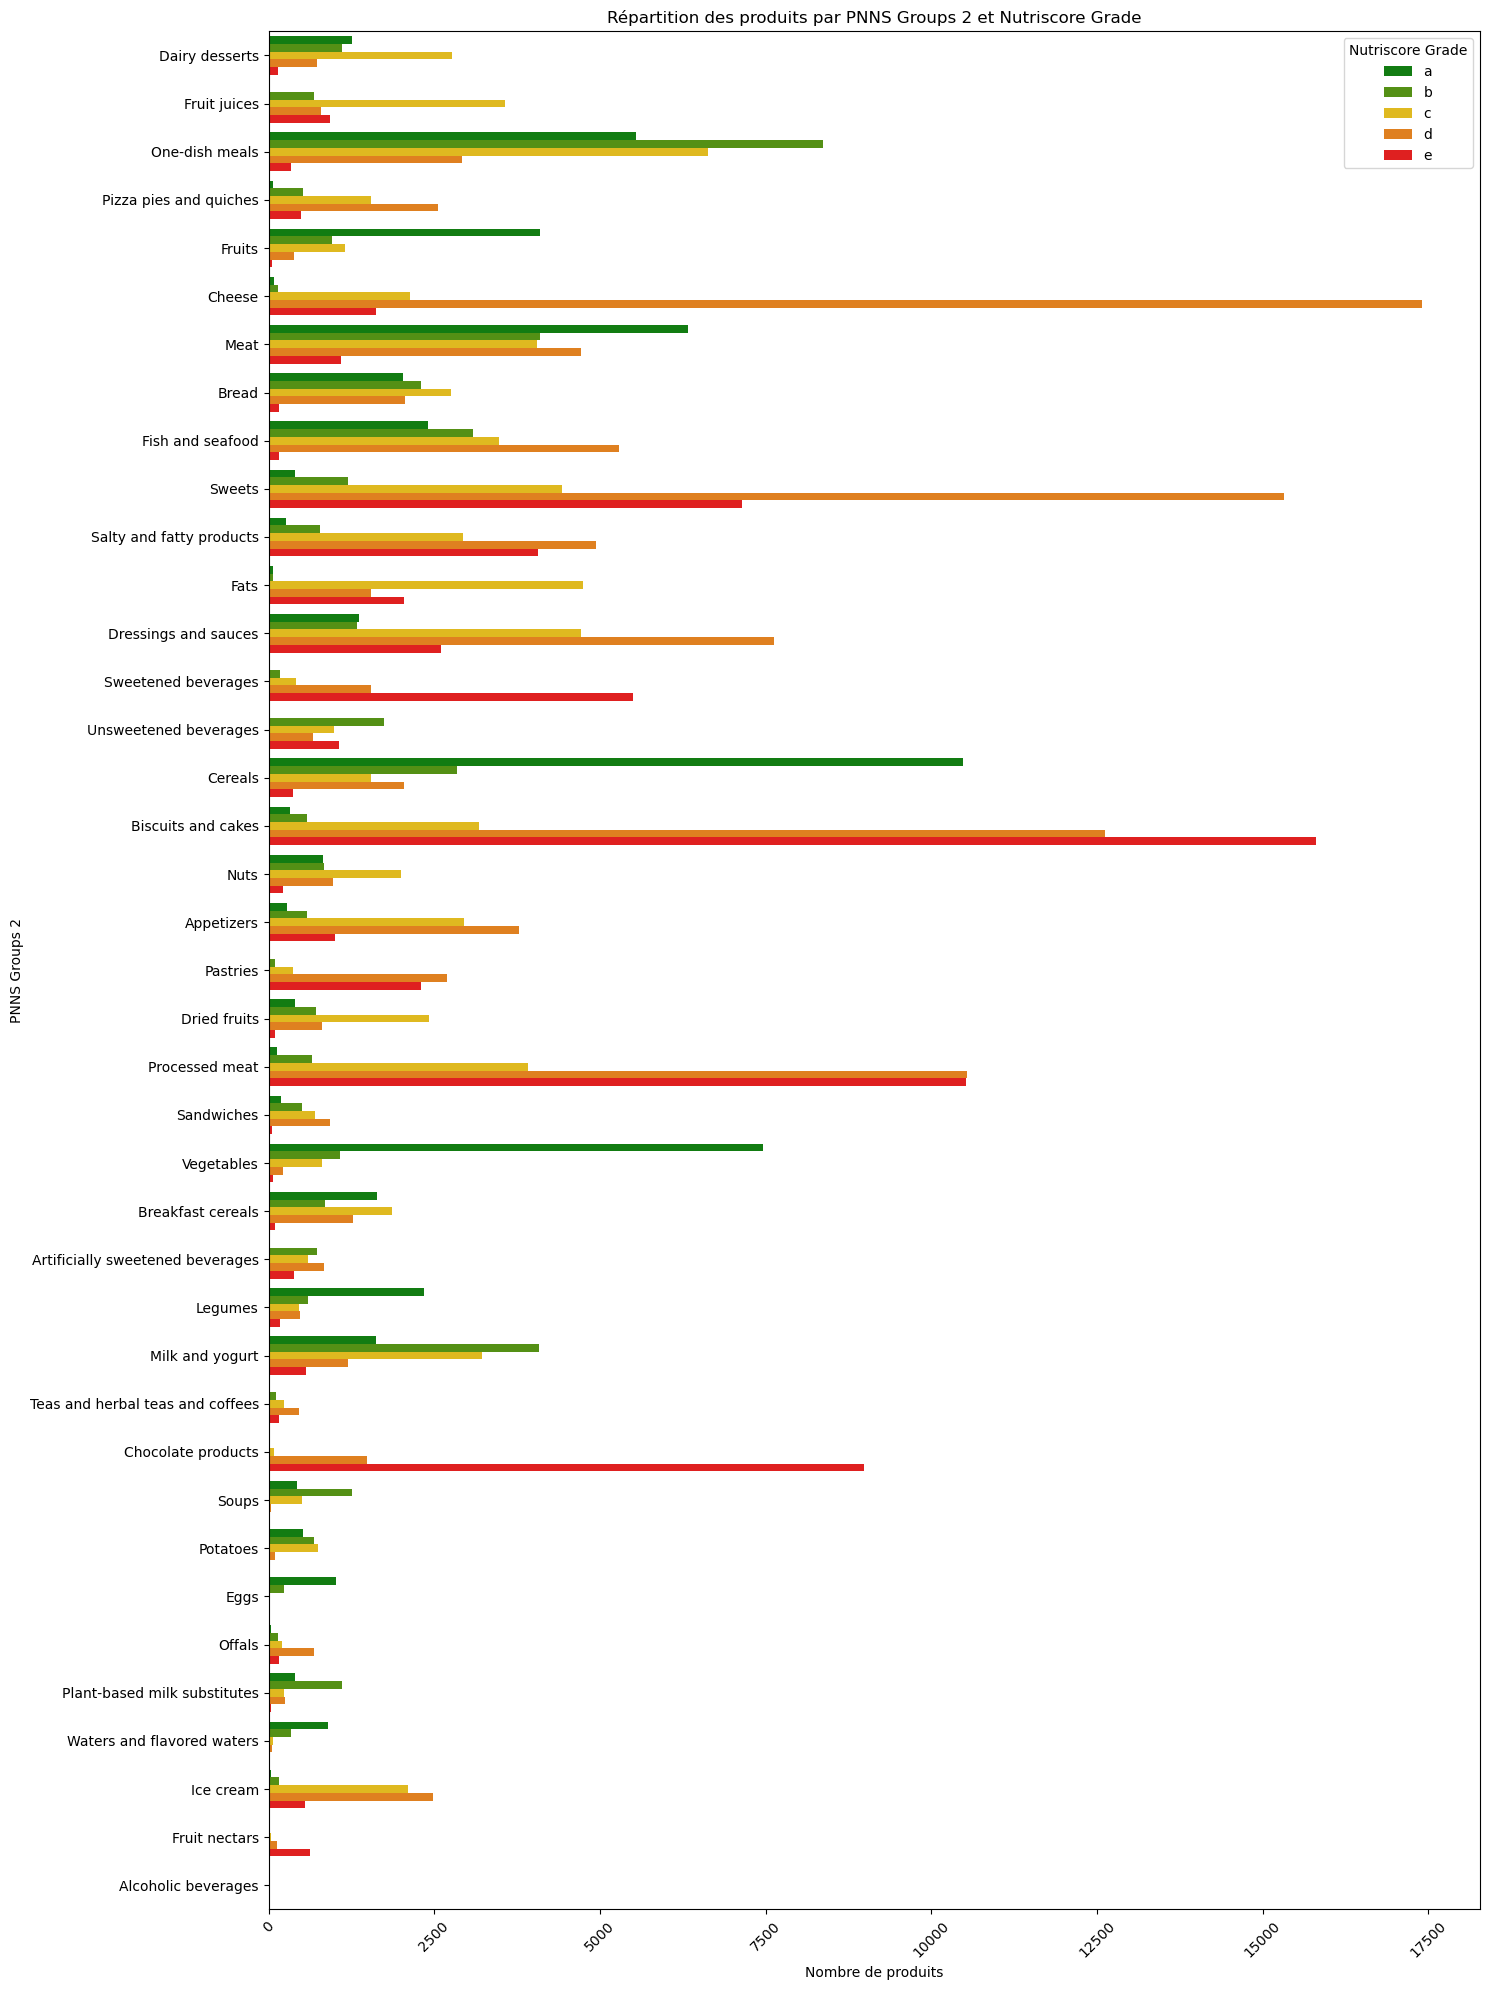

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before opera

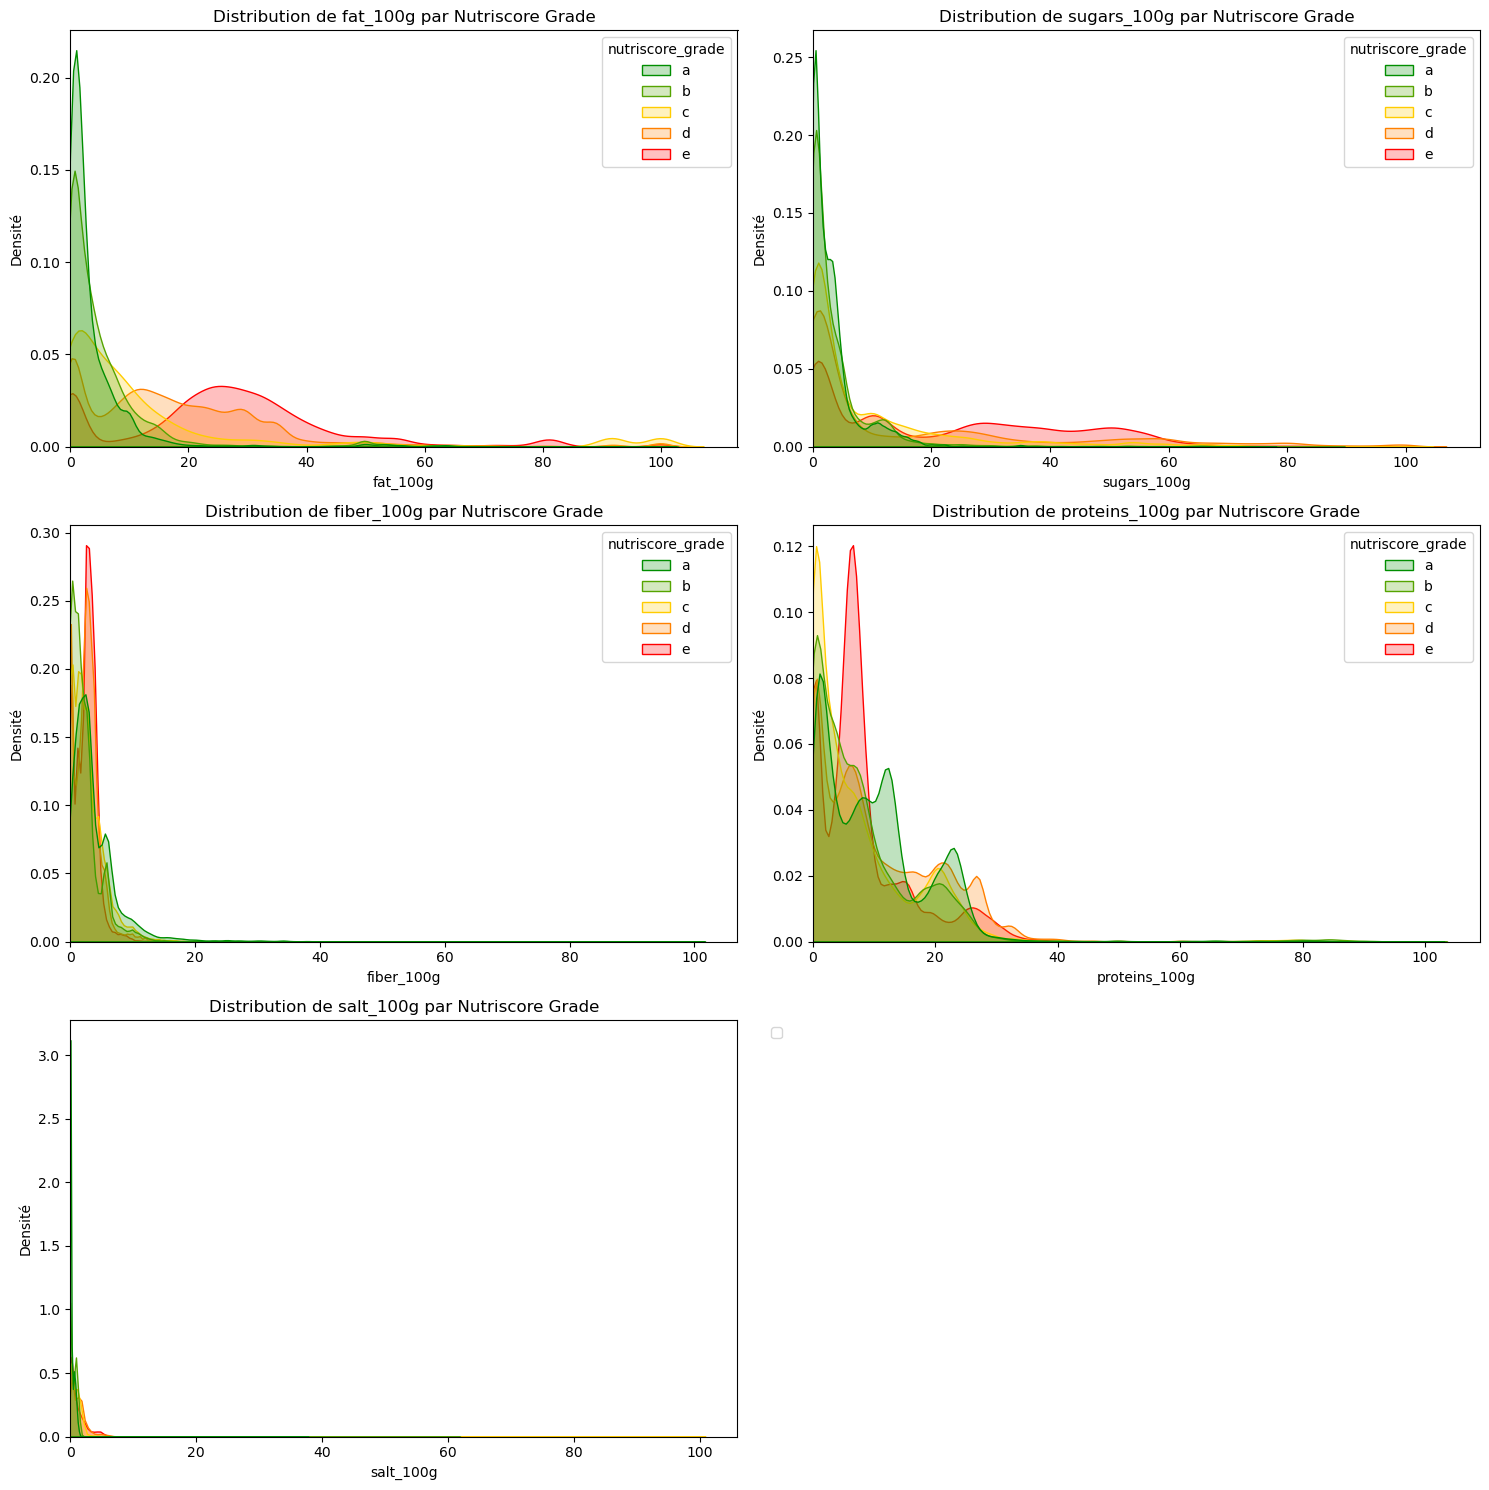

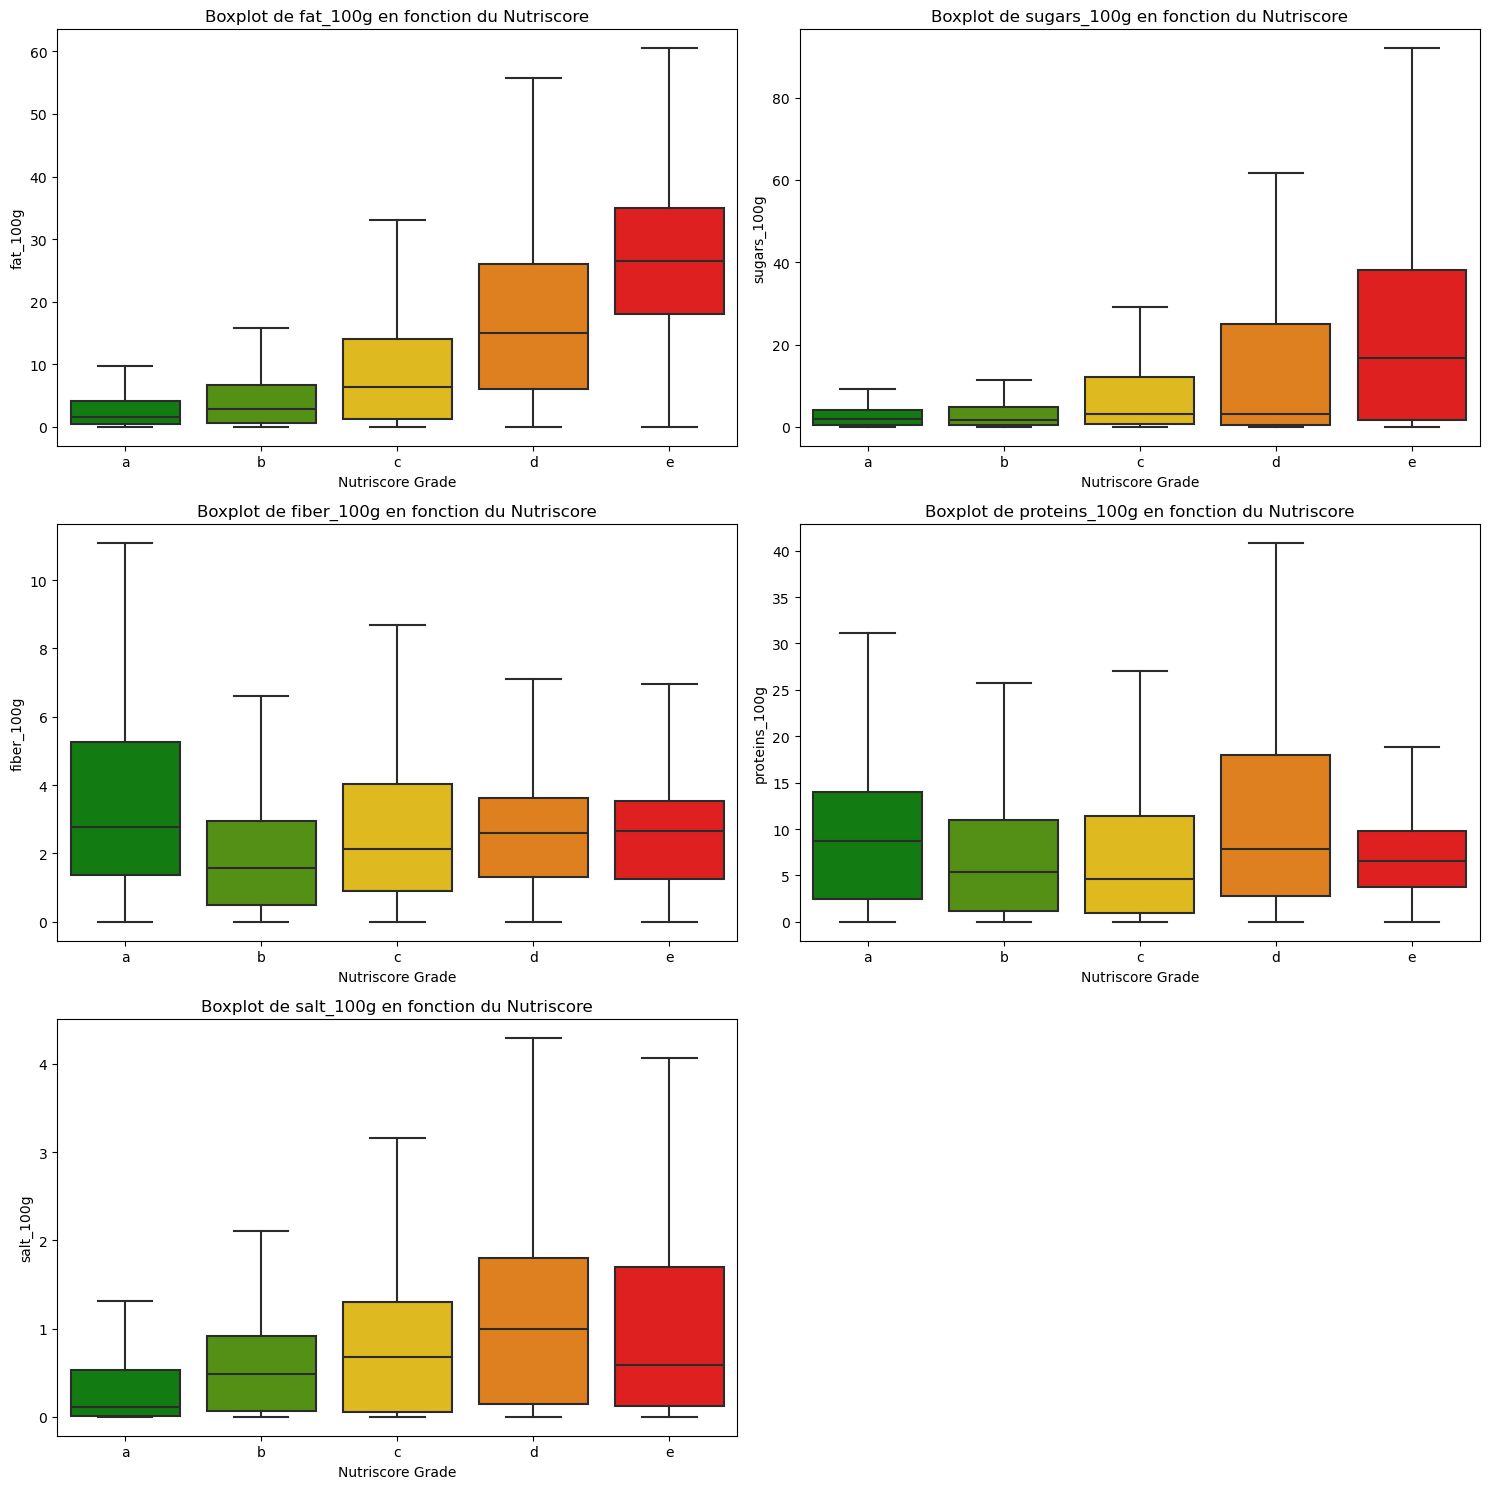

In [286]:
def generate_plots(df, variables, palette_colors):
    """
    Génère différents types de graphiques pour les données fournies dans l'ordre spécifié.
    
    Parameters:
    - df: DataFrame contenant les données.
    - variables: Liste des variables à analyser pour les boxplots et les courbes de densité.
    - palette_colors: Dictionnaire définissant les couleurs pour chaque grade Nutri-Score.
    
    Returns:
    - None
    """
    
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    df_filtre = df[~df['nutriscore_grade'].isin(['unknown', 'not-applicable'])]
    grades_ordonnes = sorted(df_filtre['nutriscore_grade'].dropna().astype(str).unique())
    palette = {grade: palette_colors.get(grade, '#C0C0C0') for grade in grades_ordonnes}

    # --- 1. Histogrammes ---
    # Histogramme pour 'energy-kcal_100g'
    plt.figure(figsize=(10, 6))
    plt.hist(df['energy-kcal_100g'].dropna(), edgecolor='black', bins=20)
    plt.xlabel('Energie (kcal)/100g')
    plt.ylabel('Fréquence')
    plt.title('Distribution Energie/100g')
    plt.grid(True)
    plt.show()

    # Histogramme pour 'sugars_100g'
    plt.figure(figsize=(10, 6))
    plt.hist(df['sugars_100g'].dropna(), edgecolor='black', bins=20)
    plt.xlabel('Sucres (g)/100g')
    plt.ylabel('Fréquence')
    plt.title('Distribution Sucres/100g')
    plt.grid(True)
    plt.show()

    # --- 2. Camembert ---
    df_filtre_sans_nan = df_filtre.dropna(subset=['nutriscore_grade'])
    score_counts = df_filtre_sans_nan['nutriscore_grade'].value_counts()
    grades_ordonnes = ['a', 'b', 'c', 'd', 'e']
    score_counts_ordonnes = score_counts.reindex(grades_ordonnes).fillna(0)
    palette = {
        'a': '#008E00',  # Vert foncé
        'b': '#55A400',  # Vert clair
        'c': '#FFCC00',  # Jaune
        'd': '#FF8000',  # Orange
        'e': '#FF0000'   # Rouge
    }
    colors = [palette.get(grade, '#C0C0C0') for grade in grades_ordonnes]
    plt.figure(figsize=(10, 7))
    plt.pie(score_counts_ordonnes, labels=grades_ordonnes, autopct='%1.1f%%', startangle=45, colors=colors)
    plt.title('Répartition des produits par Nutriscore Grade')
    plt.axis('equal')  # Assure que le camembert est un cercle
    plt.show()

    # --- 3. Countplot général ---
    comptages = df['pnns_groups_2'].value_counts()
    plt.figure(figsize=(10, 15))
    sns.countplot(data=df, y='pnns_groups_2', order=comptages.index, palette='viridis')
    plt.title('Répartition des produits par PNNS Groups 2')
    plt.ylabel('PNNS Groups 2')
    plt.xlabel('Nombre de produits')
    plt.xticks(rotation=45)
    plt.show()
    
    # --- 4. Countplot filtré avec Nutriscore Grade ---
    comptages = df_filtre['pnns_groups_2'].value_counts()
    plt.figure(figsize=(15, 20))
    sns.countplot(y='pnns_groups_2', hue='nutriscore_grade', data=df_filtre, palette=palette, hue_order=grades_ordonnes)
    plt.title('Répartition des produits par PNNS Groups 2 et Nutriscore Grade')
    plt.xlabel('Nombre de produits')
    plt.ylabel('PNNS Groups 2')
    plt.xticks(rotation=45)
    plt.legend(title='Nutriscore Grade')
    plt.tight_layout()
    plt.show()

    # --- 5. Courbes de Densité (KDE) ---
    num_vars = len(variables)
    num_rows = (num_vars + 1) // 2  # Calcul du nombre de lignes nécessaire pour les sous-graphiques
    plt.figure(figsize=(15, 5 * num_rows))  # Ajustement de la taille totale du graphique
    for i, var in enumerate(variables, start=1):
        plt.subplot(num_rows, 2, i)  # 2 colonnes, avec 'num_rows' lignes
        sns.kdeplot(data=df_filtre, x=var, hue='nutriscore_grade', fill=True, common_norm=False, hue_order=grades_ordonnes, palette=palette)
        plt.title(f'Distribution de {var} par Nutriscore Grade')
        plt.xlabel(var)
        plt.ylabel('Densité')
        plt.xlim(left=0)  # Forcer le début de l'axe x à 0
    plt.subplots_adjust(right=0.8, hspace=0.5)  # Ajustement horizontal et espace vertical
    plt.legend(bbox_to_anchor=(1.04, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

    # --- 6. Boxplots ---
    num_vars = len(variables)
    num_rows = (num_vars + 1) // 2  # Calcul du nombre de lignes nécessaire pour les sous-graphiques
    plt.figure(figsize=(15, 5 * num_rows))  # Ajustement de la taille totale du graphique
    for i, var in enumerate(variables, start=1):
        plt.subplot(num_rows, 2, i)  # 2 colonnes, avec 'num_rows' lignes
        sns.boxplot(x='nutriscore_grade', y=var, data=df_filtre, palette=palette, order=grades_ordonnes, showfliers=False)
        plt.title(f'Boxplot de {var} en fonction du Nutriscore')
        plt.xlabel('Nutriscore Grade')
        plt.ylabel(var)
    plt.tight_layout()
    plt.show()

generate_plots(df, variables, palette_colors)

## Zoom sur categories fruits / legumes

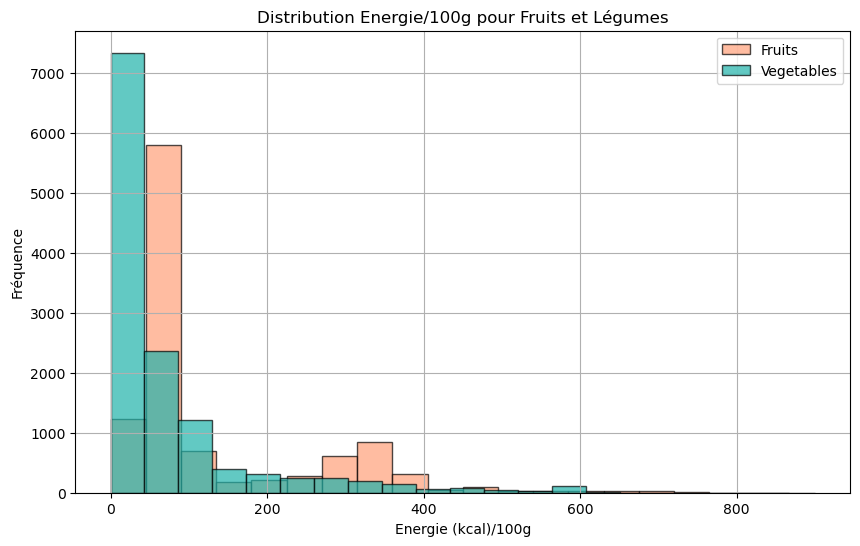

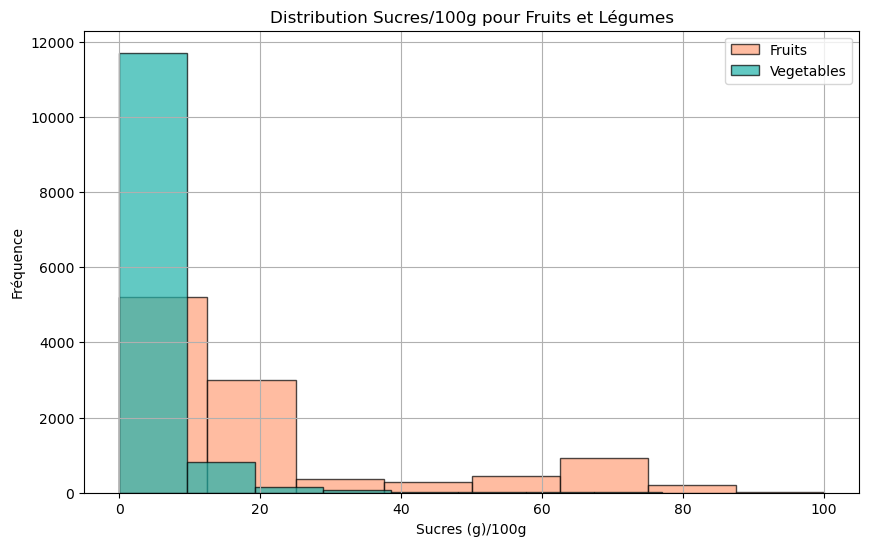

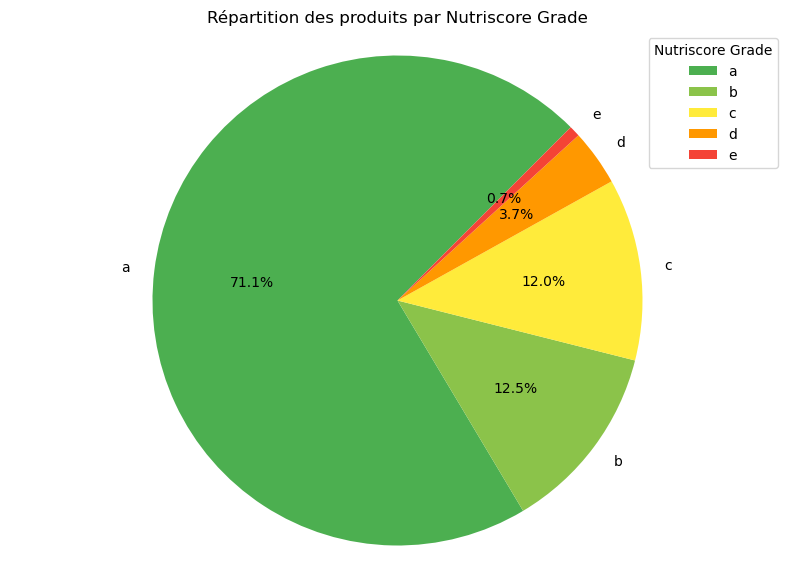

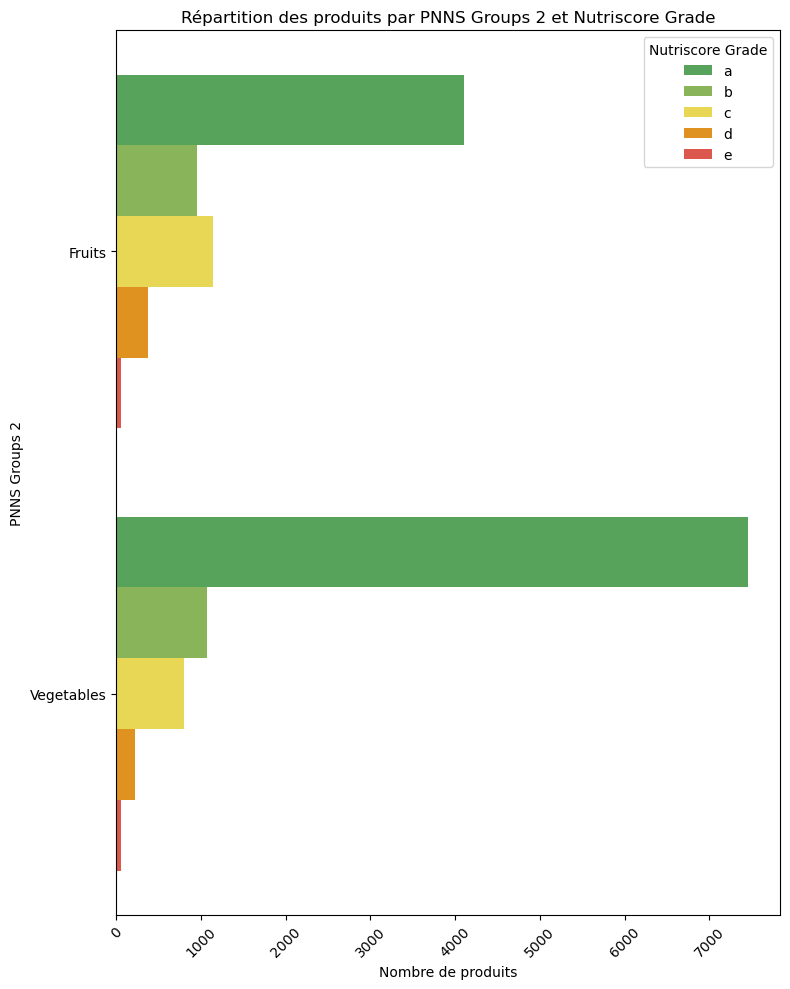

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before opera

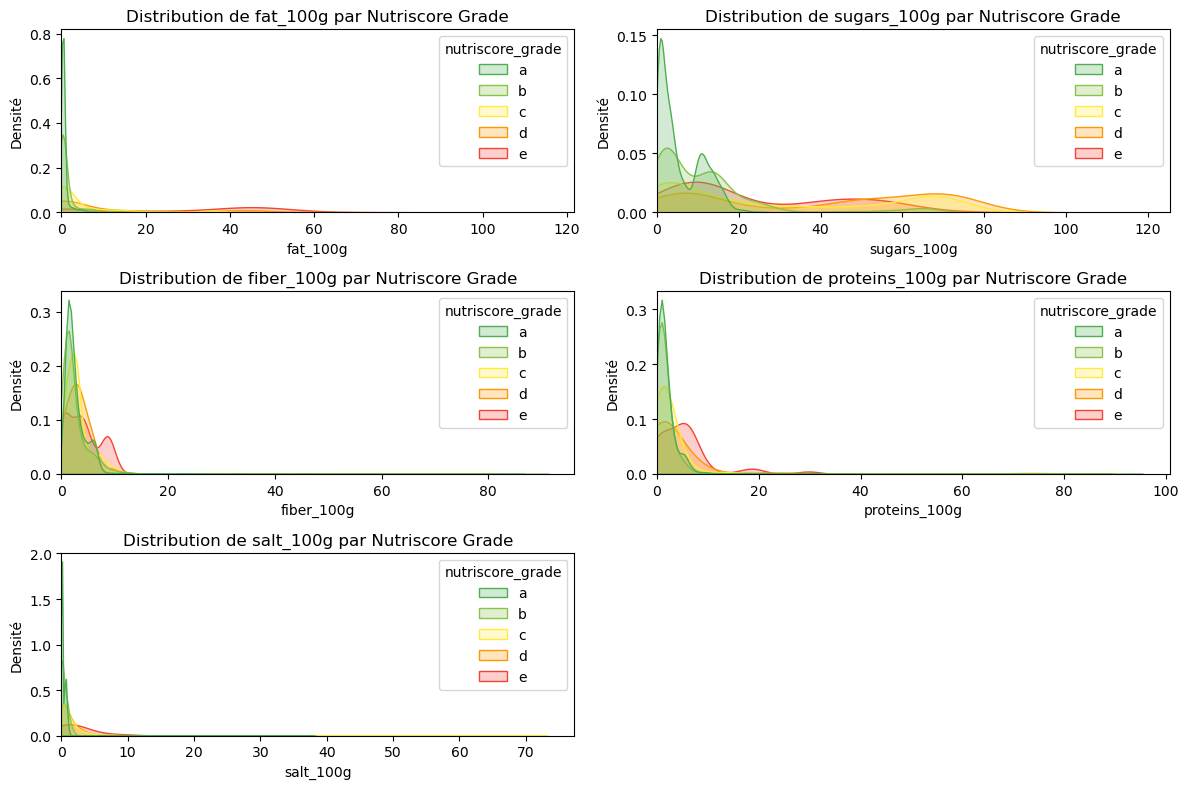

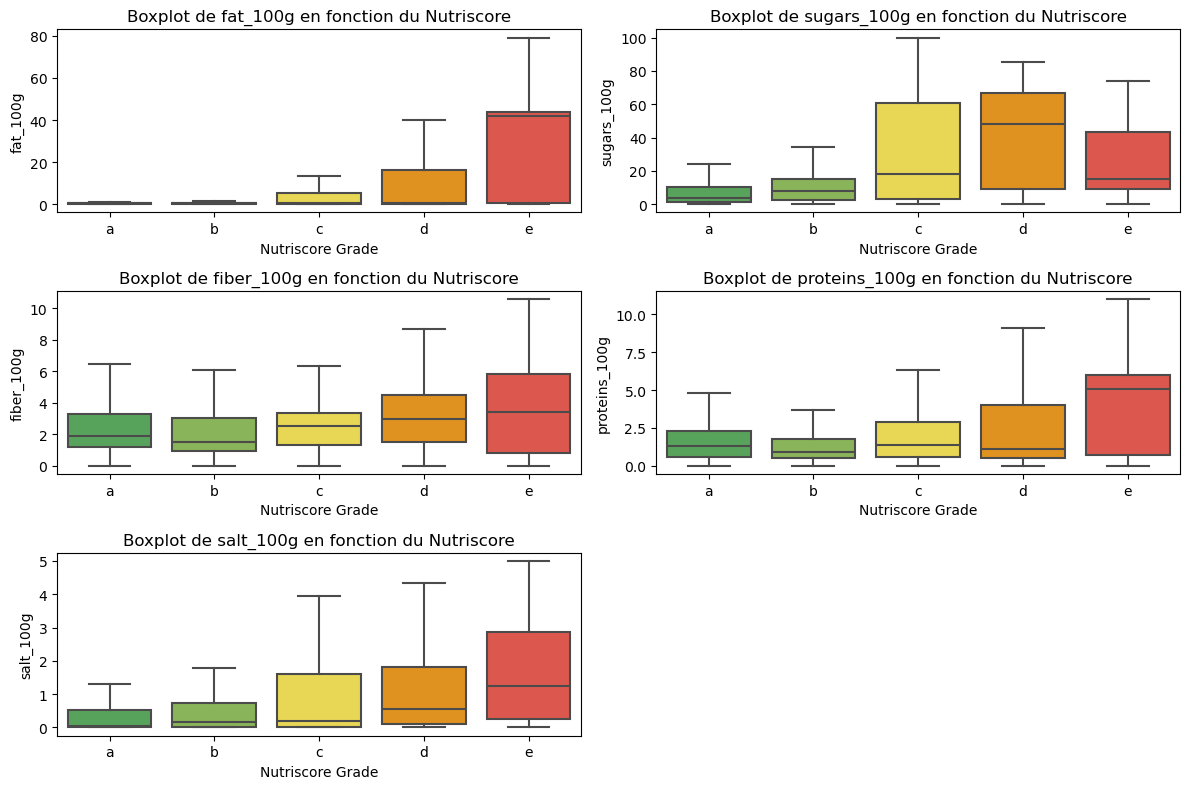

In [288]:
def generate_plots(df, variables, palette_colors):
    """
    Génère différents types de graphiques pour les données fournies dans l'ordre spécifié.
    
    Parameters:
    - df: DataFrame contenant les données.
    - variables: Liste des variables à analyser pour les boxplots et les courbes de densité.
    - palette_colors: Dictionnaire définissant les couleurs pour chaque grade Nutri-Score.
    
    Returns:
    - None
    """
    
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    df = df[df['pnns_groups_2'].isin(['Fruits', 'Vegetables'])]
    df_filtre = df[~df['nutriscore_grade'].isin(['unknown', 'not-applicable'])]
    grades_ordonnes = sorted(df_filtre['nutriscore_grade'].dropna().astype(str).unique())
    palette = {grade: palette_colors.get(grade, '#C0C0C0') for grade in grades_ordonnes}

    # Supprimer les NaN pour toutes les variables d'intérêt avant les graphes KDE et boxplots
    df_filtre = df_filtre.dropna(subset=variables + ['nutriscore_grade'])

    # --- 1. Histogrammes combinés pour Fruits et Vegetables ---
    categories = ['Fruits', 'Vegetables']
    colors = ['#FFA07A', '#20B2AA']  # Couleurs différentes pour les catégories

    plt.figure(figsize=(10, 6))
    for category, color in zip(categories, colors):
        df_category = df[df['pnns_groups_2'] == category]
        plt.hist(df_category['energy-kcal_100g'].dropna(), edgecolor='black', bins=20, alpha=0.7, label=category, color=color)
    plt.xlabel('Energie (kcal)/100g')
    plt.ylabel('Fréquence')
    plt.title('Distribution Energie/100g pour Fruits et Légumes')
    plt.legend()
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(10, 6))
    for category, color in zip(categories, colors):
        df_category = df[df['pnns_groups_2'] == category]
        plt.hist(df_category['sugars_100g'].dropna(), edgecolor='black', bins=8, alpha=0.7, label=category, color=color)
    plt.xlabel('Sucres (g)/100g')
    plt.ylabel('Fréquence')
    plt.title('Distribution Sucres/100g pour Fruits et Légumes')
    plt.legend()
    plt.grid(True)
    plt.show()

    # --- 2. Camembert ---
    score_counts = df_filtre['nutriscore_grade'].value_counts()
    score_counts_ordonnes = score_counts[grades_ordonnes]
    colors = [palette.get(grade, '#C0C0C0') for grade in grades_ordonnes]

    plt.figure(figsize=(10, 7))
    plt.pie(score_counts_ordonnes, labels=grades_ordonnes, autopct='%1.1f%%', startangle=45, colors=colors)
    plt.title('Répartition des produits par Nutriscore Grade')
    plt.axis('equal')  # Assure que le camembert est un cercle
    plt.legend(title='Nutriscore Grade')
    plt.show()

    # --- 4. Countplot filtré avec Nutriscore Grade ---
    comptages = df_filtre['pnns_groups_2'].value_counts()
    plt.figure(figsize=(8, 10))
    sns.countplot(y='pnns_groups_2', hue='nutriscore_grade', data=df_filtre, palette=palette, hue_order=grades_ordonnes)
    plt.title('Répartition des produits par PNNS Groups 2 et Nutriscore Grade')
    plt.xlabel('Nombre de produits')
    plt.ylabel('PNNS Groups 2')
    plt.xticks(rotation=45)
    plt.legend(title='Nutriscore Grade')
    plt.tight_layout()
    plt.show()

    # --- 5. Courbes de Densité (KDE) ---
    plt.figure(figsize=(12, 8))  # Ajuster la taille de la figure pour deux lignes
    num_vars = len(variables)
    num_cols = 2  # Nombre de colonnes
    num_rows = (num_vars + num_cols - 1) // num_cols  # Calculer le nombre de lignes

    for i, var in enumerate(variables, start=1):
        plt.subplot(num_rows, num_cols, i)  # Créer des sous-graphiques sur deux colonnes
        sns.kdeplot(data=df_filtre, x=var, hue='nutriscore_grade', fill=True, common_norm=False, hue_order=grades_ordonnes, palette=palette)
        plt.title(f'Distribution de {var} par Nutriscore Grade')
        plt.xlabel(var)
        plt.ylabel('Densité')
        plt.xlim(left=0)
    
    plt.tight_layout()
    plt.show()

    # --- 6. Boxplots ---
    plt.figure(figsize=(12, 8))  # Ajuster la taille de la figure pour deux lignes
    num_vars = len(variables)
    num_cols = 2  # Nombre de colonnes
    num_rows = (num_vars + num_cols - 1) // num_cols  # Calculer le nombre de lignes

    for i, var in enumerate(variables, start=1):
        plt.subplot(num_rows, num_cols, i)  # Créer des sous-graphiques sur deux colonnes
        sns.boxplot(x='nutriscore_grade', y=var, data=df_filtre, palette=palette, order=grades_ordonnes, showfliers=False)
        plt.title(f'Boxplot de {var} en fonction du Nutriscore')
        plt.xlabel('Nutriscore Grade')
        plt.ylabel(var)
    
    plt.tight_layout()
    plt.show()

generate_plots(df, variables, palette_colors)


# Test de kruskal wallis

Ce code effectue des tests statistiques pour comparer les distributions de plusieurs colonnes nutritionnelles. D'abord, il sélectionne cinq colonnes de données nutritionnelles ('sugars_100g', 'fat_100g', 'proteins_100g', 'fiber_100g', et 'carbohydrates_100g') et crée une liste de ces colonnes en excluant les valeurs manquantes. Ensuite, pour chaque paire de colonnes, il utilise le test de Kruskal-Wallis pour comparer leurs distributions. Si la valeur p obtenue est inférieure à 0,02 (indiquant une différence statistiquement significative), le compteur rejected_count est incrémenté ; sinon, not_rejected_count est incrémenté. Enfin, le code affiche le nombre total d'hypothèses nulles rejetées.

In [291]:
data_columns = ['sugars_100g', 'fat_100g', 'proteins_100g', 'fiber_100g', 'carbohydrates_100g']

data_list = [df[col].dropna() for col in data_columns]

rejected_count = 0
not_rejected_count = 0
alpha = 0.02

for i in range(len(data_list)):
    for j in range(i + 1, len(data_list)):
        data1 = data_list[i]
        data2 = data_list[j]
        
        stat, p_value = stats.kruskal(data1, data2)
        
        if p_value < alpha:
            rejected_count += 1
        else:
            not_rejected_count += 1
        
print(f"\nHypothèses rejetées : {rejected_count}")


Hypothèses rejetées : 10


# ACP

Cette fonction analyze_pca réalise une analyse en composantes principales (PCA). Elle commence par filtrer les lignes avec des valeurs valides de 'nutriscore_grade' ('a' à 'e'), puis normalise certaines colonnes nutritionnelles. Ensuite, elle applique la PCA pour réduire la dimensionnalité des données et crée un DataFrame des résultats de la PCA. Plusieurs visualisations sont générées : un graphique des valeurs propres pour évaluer l'importance des composantes principales, un biplot montrant la relation entre les variables et les composantes principales, un cercle de corrélation illustrant les contributions des variables, des graphiques des scores des individus selon leur 'nutriscore_grade' avec ajout de polygones convexes pour les inliers, et un graphique des contributions des variables aux composantes principales. Ces visualisations aident à interpréter les résultats de la PCA et à comprendre les relations entre les variables nutritionnelles et les scores Nutri-Score.

Nombre total de lignes à analyser après filtrage : 386333


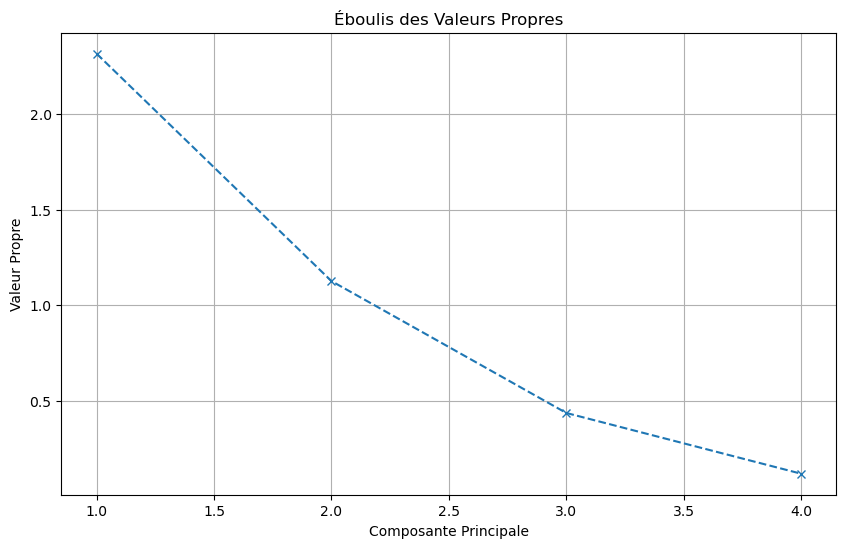

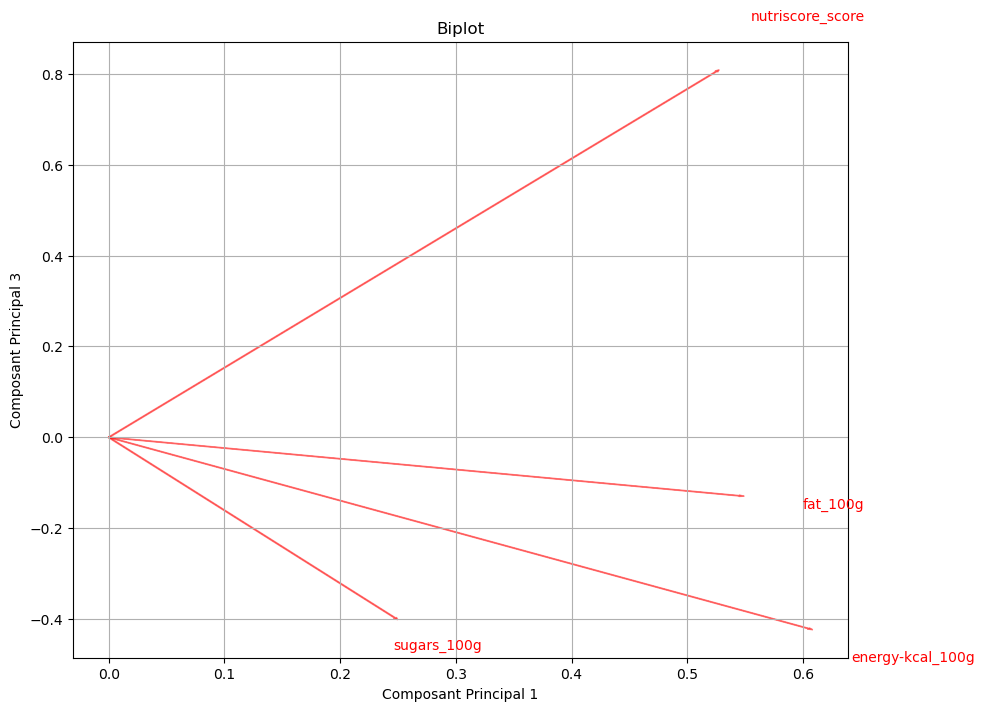

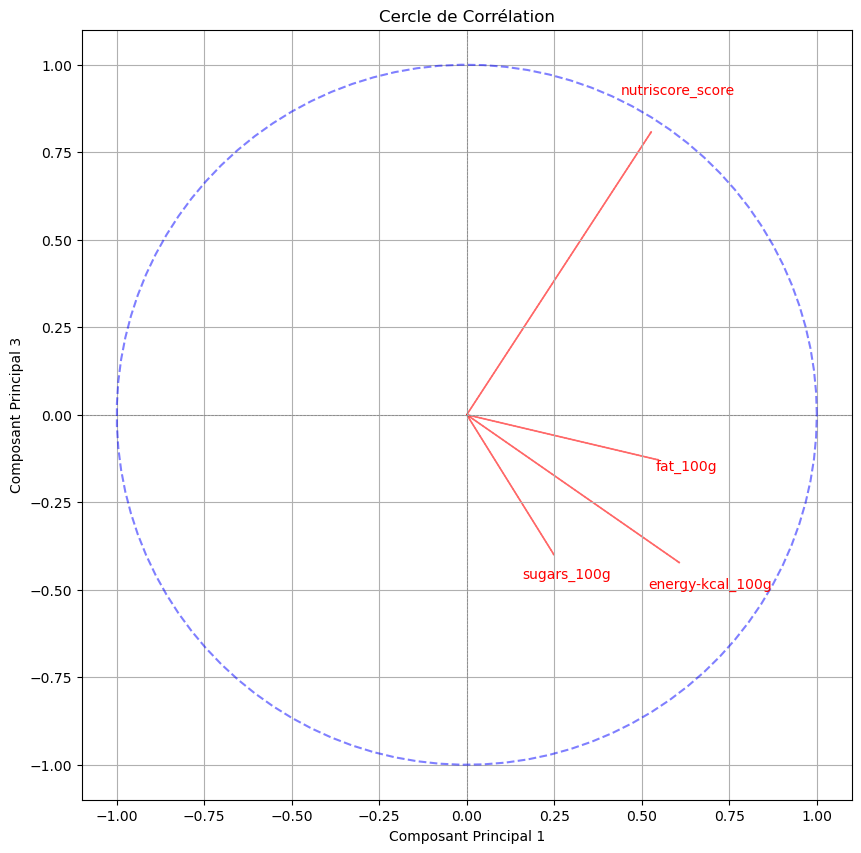

In [ ]:
def analyze_pca(df):
    df['nutriscore_grade'] = df['nutriscore_grade'].astype(str).str.lower()
    valid_scores = ['a', 'b', 'c', 'd', 'e']
    df_filtered = df[df['nutriscore_grade'].isin(valid_scores)]
    print(f"Nombre total de lignes à analyser après filtrage : {df_filtered.shape[0]}")
    data_columns = ['sugars_100g', 'fat_100g', 'nutriscore_score', 'energy-kcal_100g']
    scaler = StandardScaler()
    data_scaled = scaler.fit_transform(df_filtered[data_columns])

    pca = PCA(n_components=len(data_columns))
    pca_results = pca.fit_transform(data_scaled)
    pca_results_df = pd.DataFrame(data=pca_results, columns=[f'PC{i+1}' for i in range(len(data_columns))])
    pca_results_df['nutriscore_grade'] = df_filtered['nutriscore_grade'].values
    palette = {
        'a': '#007f3e',  # Vert foncé
        'b': '#58b252',  # Vert clair
        'c': '#f6c23e',  # Jaune
        'd': '#f35e29',  # Orange
        'e': '#e40613'   # Rouge
    }

    # Fonction pour ajouter un polygone convexe autour des points sans outliers
    def add_convex_hull(ax, data, color, label):
        if len(data) < 3:
            return
        
        mcd = MinCovDet().fit(data)
        mahalanobis_distances = mcd.mahalanobis(data)
        is_inlier = mahalanobis_distances < np.percentile(mahalanobis_distances, 98)
        inliers = data[is_inlier]
        
        if len(inliers) < 3:
            return
        
        hull = ConvexHull(inliers)
        ax.fill(inliers[hull.vertices, 0], inliers[hull.vertices, 1], color=color, alpha=1, label=label)

    # Éboulis des valeurs propres (Scree Plot des valeurs propres)
    def plot_eigenvalues(pca):
        plt.figure(figsize=(10, 6))
        plt.plot(range(1, len(pca.explained_variance_) + 1), pca.explained_variance_, marker='x', linestyle='--')
        plt.title('Éboulis des Valeurs Propres')
        plt.xlabel('Composante Principale')
        plt.ylabel('Valeur Propre')
        plt.grid(True)
        plt.show()

    # Graphique des charges des variables (Biplot)
    def plot_biplot(pca, feature_names):
        plt.figure(figsize=(10, 8))
        pc1 = pca.components_[0]
        pc3 = pca.components_[2]
        
        for i, feature in enumerate(feature_names):
            plt.arrow(0, 0, pc1[i], pc3[i], color='r', alpha=0.5)
            plt.text(pc1[i]*1.15, pc3[i]*1.15, feature, color='r', ha='center', va='center')
        
        plt.xlabel('Composant Principal 1')
        plt.ylabel('Composant Principal 3')
        plt.title('Biplot')
        plt.grid(True)
        plt.show()

    # Cercle de Corrélation
    def plot_circles(pca, feature_names):
        plt.figure(figsize=(10, 10))
        plt.axhline(0, color='grey', linestyle='--', linewidth=0.5)
        plt.axvline(0, color='grey', linestyle='--', linewidth=0.5)
        
        pc1 = pca.components_[0]
        pc3 = pca.components_[2]
        
        for i, feature in enumerate(feature_names):
            plt.arrow(0, 0, pc1[i], pc3[i], color='r', alpha=0.5)
            plt.text(pc1[i]*1.15, pc3[i]*1.15, feature, color='r', ha='center', va='center')

        theta = np.linspace(0, 2 * np.pi, 100)
        plt.plot(np.cos(theta), np.sin(theta), 'b--', alpha=0.5)
        
        plt.xlabel('Composant Principal 1')
        plt.ylabel('Composant Principal 3')
        plt.title('Cercle de Corrélation')
        plt.grid(True)
        plt.gca().set_aspect('equal', adjustable='box')
        plt.show()

    # Graphique des scores des individus (PC1 vs PC3)
    def plot_scores(pca_results_df, pc1, pc3):
        fig, axes = plt.subplots(2, 3, figsize=(20, 12), sharex=True, sharey=True)
        plt.subplots_adjust(wspace=0.4, hspace=0.4)

        valid_scores = ['a', 'b', 'c', 'd', 'e']
        for i, score in enumerate(valid_scores):
            subset = pca_results_df[pca_results_df['nutriscore_grade'] == score]
            num_individuals = len(subset)
            ax = axes[i // 3, i % 3]  # Indexation correcte des sous-graphes
            ax.scatter(subset[pc1], subset[pc3], color=palette[score], s=50, edgecolor='k', alpha=0.7)
            add_convex_hull(ax, subset[[pc1, pc3]].values, palette[score], f'Nutri-Score {score.upper()}')
            ax.set_xlabel(pc1)
            ax.set_ylabel(pc3)
            ax.set_title(f'Nutri-Score {score.upper()}\nNombre d\'individus : {num_individuals}')
            ax.grid(True)

        # Graphique combiné pour tous les scores sur une ligne seul
        plt.figure(figsize=(20, 10))  # Taille plus grande pour une meilleure lisibilité
        ax_all = plt.gca()  # Obtenir les axes de la figure en cours
        for score in valid_scores:
            subset = pca_results_df[pca_results_df['nutriscore_grade'] == score]
            add_convex_hull(ax_all, subset[[pc1, pc3]].values, palette[score], f'Nutri-Score {score.upper()}')
        ax_all.set_xlabel(pc1)
        ax_all.set_ylabel(pc3)
        ax_all.set_title('Tous les Nutri-Scores')
        ax_all.grid(True)
        ax_all.legend()

        plt.show()

    # Graphique des contributions des variables à chaque composant
    def plot_variable_contributions(pca, feature_names):
        plt.figure(figsize=(12, 6))
        for i in range(pca.components_.shape[0]):
            plt.plot(pca.components_[i, :], marker='o', label=f'PC{i+1}')
        
        plt.xticks(ticks=np.arange(len(feature_names)), labels=feature_names, rotation=45)
        plt.xlabel('Variables')
        plt.ylabel('Contributions')
        plt.title('Contributions des Variables aux Composantes Principales')
        plt.legend()
        plt.grid(True)
        plt.show()


    plot_eigenvalues(pca)
    plot_biplot(pca, data_columns)
    plot_circles(pca, data_columns)
    plot_scores(pca_results_df, 'PC1', 'PC3')
    plot_variable_contributions(pca, data_columns)


analyze_pca(df)


# Timer

In [ ]:
end_time = time.time()
execution_time = end_time - start_time

print(f"Temps d'exécution total du notebook : {execution_time:.4f} secondes")

# test fin

In [ ]:
zero_percentages = (df == 0).sum() / df.shape[0] * 100
nan_percentages = df.isna().sum() / df.shape[0] * 100
print("Pourcentage des valeurs égales à 0 :")
print(zero_percentages)
print("\nPourcentage des NaN :")
print(nan_percentages)

In [ ]:
df.isna().sum()

In [ ]:
pd.set_option('display.float_format', '{:.2f}'.format)
print(df.describe())

In [ ]:
df.head(10)

In [ ]:
df.info